In [94]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels
import seaborn as sns

In [95]:
sys.path.insert(0, os.path.split(os.path.abspath(""))[0])
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))

In [96]:
from preprocessing import CsvRefactorer
from analytics import WaterFlowRates
from statistics import Statistics as st
from data_engineering import PeriodicDataPreprocess, FeatureEngineering
from statistics import *
from statsmodels.tsa.seasonal import seasonal_decompose

In [97]:
csv = pd.read_csv("140423_090623_2nd_circuit.csv")

In [131]:
refac = CsvRefactorer(csv)

In [132]:
ids = refac.ids
ids

array([299, 309, 315, 317, 319, 321, 325, 327, 406, 407, 408, 409, 460,
       461, 462, 463, 481])

In [133]:
dfs_list = refac.select_by_ids(ids)

In [134]:
dfs_list = refac.min_frac_groupby(60, * dfs_list)

In [135]:
df = refac.concat_dfs(dfs_list)

In [136]:
df = df.rename(columns=refac.ids_mapping())

In [137]:
time_periods = [
    ("2023-04-17","2023-04-21"), ("2023-05-02","2023-05-05"), ("2023-05-08","2023-05-12"),
    ("2023-05-15","2023-05-19"), ("2023-05-22","2023-05-26"), ("2023-05-29","2023-06-02"),
    ("2023-06-05","2023-06-09"),
]

In [138]:
periods_df = refac.select_time_period(df, time_periods)

In [139]:
pdp = PeriodicDataPreprocess(periods_df.copy())

In [140]:
pdp.conditional_rows_drop(["p21", "p22", "p23", "p24"], "eq", 0.0)

{'2023-04-17 2023-04-21':                          T1aHE        P2      T1bHE      T2bHE      T2aHE  \
 Timestamp                                                                   
 2023-04-17 09:00:00  29.400000  0.010000  26.397479  21.600000  26.596639   
 2023-04-17 10:00:00  29.400000  0.010000  26.353556  21.514815  26.564115   
 2023-04-17 11:00:00  29.399447  0.010000  26.328820  21.500000  26.500000   
 2023-04-17 12:00:00  29.317948  0.010000  26.303743  21.455263  26.500000   
 2023-04-17 13:00:00  29.299999  0.010000  26.299999  21.400000  26.500000   
 ...                        ...       ...        ...        ...        ...   
 2023-04-21 11:00:00  43.053226  0.470500  49.105405  26.422752  31.981250   
 2023-04-21 12:00:00  43.060914  0.470339  49.210472  25.887317  31.623000   
 2023-04-21 13:00:00  41.291837  0.470333  47.542132  23.545685  29.424365   
 2023-04-21 14:00:00  39.816837  0.470333  46.076142  21.712683  27.675243   
 2023-04-21 15:00:00  32.527014  0.4190

In [141]:
pdp.sma_smoothing(10)


{'2023-04-17 2023-04-21':                          T1aHE        P2      T1bHE      T2bHE      T2aHE  \
 Timestamp                                                                   
 2023-04-17 09:00:00  28.317242  0.139539  26.709461  20.941669  25.025590   
 2023-04-17 10:00:00  28.569036  0.184687  27.574670  21.310996  25.116810   
 2023-04-17 11:00:00  29.576309  0.231587  29.407395  21.710854  25.492160   
 2023-04-17 12:00:00  30.717395  0.278370  31.446331  22.059945  25.886424   
 2023-04-17 13:00:00  31.875653  0.325218  33.556435  22.213454  26.146776   
 ...                        ...       ...        ...        ...        ...   
 2023-04-21 01:00:00  43.043499  0.470801  49.126686  26.252803  31.883386   
 2023-04-21 02:00:00  43.002472  0.470785  49.085080  26.215078  31.841511   
 2023-04-21 03:00:00  42.967481  0.470819  49.059877  26.131035  31.769609   
 2023-04-21 04:00:00  42.770819  0.470852  48.880988  25.834962  31.499314   
 2023-04-21 05:00:00  42.438759  0.4708

In [142]:

pdp.filter_by_zscore(column="Q2")
pdp.filter_by_zscore(column="dt1")
pdp.filter_by_zscore(column="dt2")

{'2023-04-17 2023-04-21':                          T1aHE        P2      T1bHE      T2bHE      T2aHE  \
 Timestamp                                                                   
 2023-04-17 20:00:00  39.530380  0.478495  45.842162  22.143674  28.047338   
 2023-04-18 02:00:00  40.109046  0.477125  46.490138  22.640340  28.568188   
 2023-04-18 03:00:00  40.556622  0.476329  46.915870  23.211153  29.111080   
 2023-04-18 04:00:00  40.906494  0.475329  47.246310  23.640416  29.521584   
 2023-04-18 05:00:00  41.197546  0.474329  47.516185  24.018838  29.875230   
 ...                        ...       ...        ...        ...        ...   
 2023-04-21 01:00:00  43.043499  0.470801  49.126686  26.252803  31.883386   
 2023-04-21 02:00:00  43.002472  0.470785  49.085080  26.215078  31.841511   
 2023-04-21 03:00:00  42.967481  0.470819  49.059877  26.131035  31.769609   
 2023-04-21 04:00:00  42.770819  0.470852  48.880988  25.834962  31.499314   
 2023-04-21 05:00:00  42.438759  0.4708

In [143]:
pdp.pumps_mapping(columns=["p21", "p22", "p23", "p24"], drop_pumps=False)

['p21', 'p22', 'p23', 'p24']


{'2023-04-17 2023-04-21':                          T1aHE        P2      T1bHE      T2bHE      T2aHE  \
 Timestamp                                                                   
 2023-04-17 20:00:00  39.530380  0.478495  45.842162  22.143674  28.047338   
 2023-04-18 02:00:00  40.109046  0.477125  46.490138  22.640340  28.568188   
 2023-04-18 03:00:00  40.556622  0.476329  46.915870  23.211153  29.111080   
 2023-04-18 04:00:00  40.906494  0.475329  47.246310  23.640416  29.521584   
 2023-04-18 05:00:00  41.197546  0.474329  47.516185  24.018838  29.875230   
 ...                        ...       ...        ...        ...        ...   
 2023-04-21 01:00:00  43.043499  0.470801  49.126686  26.252803  31.883386   
 2023-04-21 02:00:00  43.002472  0.470785  49.085080  26.215078  31.841511   
 2023-04-21 03:00:00  42.967481  0.470819  49.059877  26.131035  31.769609   
 2023-04-21 04:00:00  42.770819  0.470852  48.880988  25.834962  31.499314   
 2023-04-21 05:00:00  42.438759  0.4708

In [144]:
# corrections to pumps2


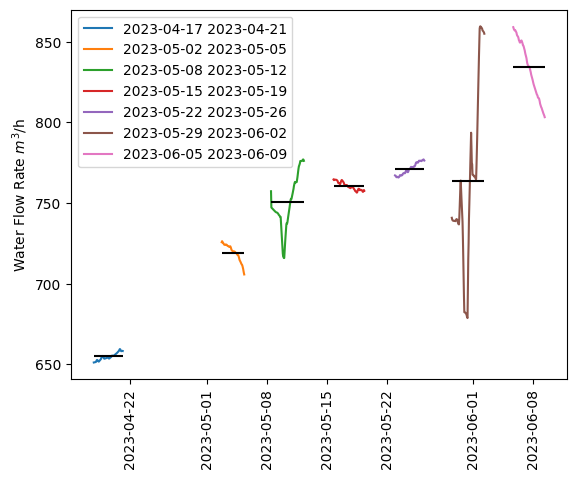

In [145]:
weeks = list(pdp.period_keys)
for i in weeks:
    plt.plot(pdp.period[i]["Q2"], label=i)
    plt.hlines(
        pdp.period[i]["Q2"].mean(),
        pdp.period[i]["Q2"].index[0],
        pdp.period[i]["Q2"].index[-1],
        color="black"
        
)
plt.ylabel("Water Flow Rate $m^3$/h")
plt.xticks(rotation=90)
plt.legend()

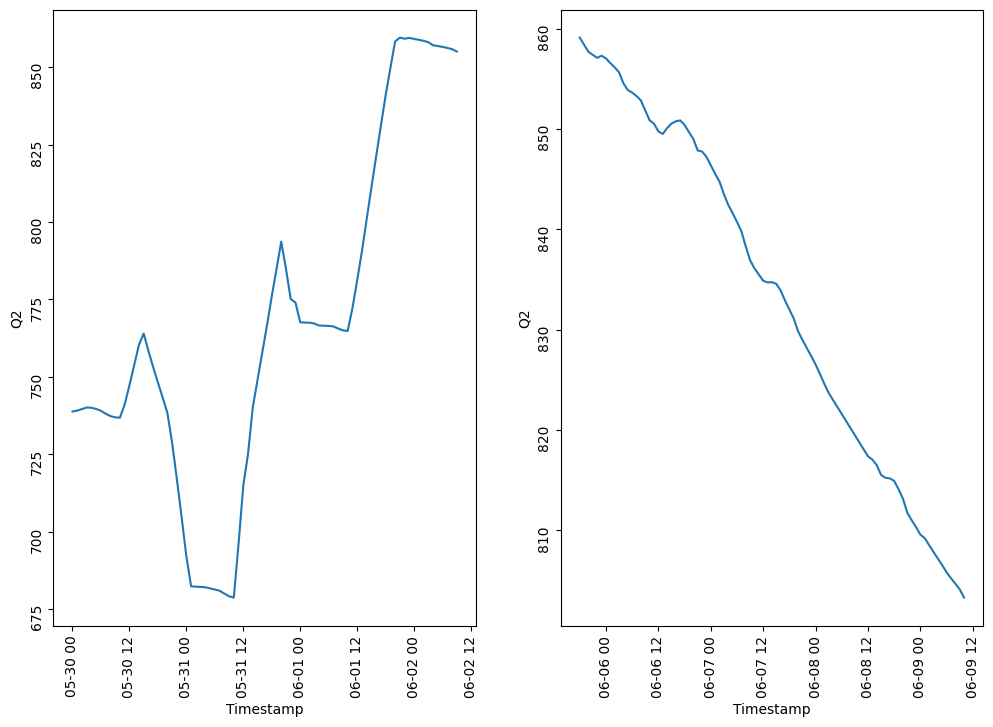

In [146]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
sns.lineplot(pdp.period["2023-05-29 2023-06-02"].loc["2023-05-30": "2023-06-02","Q2"], ax=axs[0])
sns.lineplot(pdp.period["2023-06-05 2023-06-09"]["Q2"], ax=axs[1])

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

In [147]:
df = pdp.to_dataframe()

In [148]:
df.loc["2023-05-30 19:00": "2023-05-30 22:00", "Q2"]

Timestamp
2023-05-30 19:00:00    743.357500
2023-05-30 20:00:00    738.361250
2023-05-30 21:00:00    728.723333
2023-05-30 22:00:00    717.009167
Name: Q2, dtype: float64

In [149]:
fe = FeatureEngineering(df)

In [150]:
fe.columns_averaging(columns=["p21", "p22", "p23", "p24"], omitbelow=50, feature_name="I2mean")

['p21', 'p22', 'p23', 'p24']


T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-04-17 20:00:00  39.530380  0.478495  45.842162  22.143674  28.047338   
2023-04-18 02:00:00  40.109046  0.477125  46.490138  22.640340  28.568188   
2023-04-18 03:00:00  40.556622  0.476329  46.915870  23.211153  29.111080   
2023-04-18 04:00:00  40.906494  0.475329  47.246310  23.640416  29.521584   
2023-04-18 05:00:00  41.197546  0.474329  47.516185  24.018838  29.875230   
...                        ...       ...        ...        ...        ...   
2023-06-09 06:00:00  46.490538  0.465088  53.105898  27.408487  33.247251   
2023-06-09 07:00:00  46.463895  0.465514  53.079562  27.349617  33.194609   
2023-06-09 08:00:00  46.395407  0.465814  53.017473  27.227741  33.084313   
2023-06-09 09:00:00  46.280309  0.465964  52.909479  27.052591  32.921800   
2023-06-09 10:00:00  44.792887  0.466114  50.908553  26.682072  32.209406   

                      Treactor     T2aHE1       Tair         p21         p22  \
Timestamp                                                                      
2023-04-17 20:00:00  40.585695  27.966404 -10.934803  144.787221  142.211460   
2023-04-18 02:00:00  41.233977  28.490843 -11.061506  143.953027  141.268147   
2023-04-18 03:00:00  41.637631  29.026223 -10.270598  143.679579  140.960258   
2023-04-18 04:00:00  41.951801  29.432540  -9.415728  143.270176  140.514770   
2023-04-18 05:00:00  42.223429  29.783944  -8.552057  142.791341  139.993158   
...                        ...        ...        ...         ...         ...   
2023-06-09 06:00:00  48.387894  33.086449  24.625769    1.011224  139.740269   
2023-06-09 07:00:00  48.363288  33.030437  23.908962    1.141287  139.377767   
2023-06-09 08:00:00  48.305505  32.917730  22.923981    1.164772  139.065254   
2023-06-09 09:00:00  48.199854  32.751942  21.654916    1.002179  139.032117   
2023-06-09 10:00:00  46.081852  32.033081  20.295496    1.077885  139.131215   

                     ...     T2aHE3     T2aHE4     T2aHE5          Q2  \
Timestamp            ...                                                
2023-04-17 20:00:00  ...  29.525234  27.865732  28.044729  651.196667   
2023-04-18 02:00:00  ...  30.045663  28.376664  28.740018  651.504167   
2023-04-18 03:00:00  ...  30.579817  28.918769  28.839805  651.998333   
2023-04-18 04:00:00  ...  30.985675  29.327908  28.941720  652.505417   
2023-04-18 05:00:00  ...  31.335047  29.682097  29.047413  652.761667   
...                  ...        ...        ...        ...         ...   
2023-06-09 06:00:00  ...  35.490966  33.497942  32.329398  805.804583   
2023-06-09 07:00:00  ...  35.438519  33.446186  32.276864  805.223333   
2023-06-09 08:00:00  ...  35.329987  33.336029  32.166769  804.670000   
2023-06-09 09:00:00  ...  35.169077  33.172976  32.004625  804.108333   
2023-06-09 10:00:00  ...  34.352993  32.455044  31.338717  803.285000   

                          dt1       dt2  pumps2  dt_circuits_coef  \
Timestamp                                                           
2023-04-17 20:00:00  6.311782  5.903664     123          2.070215   
2023-04-18 02:00:00  6.381092  5.927848     123          2.053420   
2023-04-18 03:00:00  6.359248  5.899928     123          2.021264   
2023-04-18 04:00:00  6.339816  5.881169     123          1.998540   
2023-04-18 05:00:00  6.318639  5.856393     123          1.978288   
...                       ...       ...     ...               ...   
2023-06-09 06:00:00  6.615359  5.838764     234          1.937571   
2023-06-09 07:00:00  6.615667  5.844992     234          1.940779   
2023-06-09 08:00:00  6.622067  5.856572     234          1.947186   
2023-06-09 09:00:00  6.629170  5.869209     234          1.955801   
2023-06-09 10:00:00  6.115666  5.527334     234          1.907968   

                     dt_circuits_coef_delta      I2mean  
Timestamp                                                
2023-04-17 20:00:0

In [151]:
fe.make_QbyIP()

T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-04-17 20:00:00  39.530380  0.478495  45.842162  22.143674  28.047338   
2023-04-18 02:00:00  40.109046  0.477125  46.490138  22.640340  28.568188   
2023-04-18 03:00:00  40.556622  0.476329  46.915870  23.211153  29.111080   
2023-04-18 04:00:00  40.906494  0.475329  47.246310  23.640416  29.521584   
2023-04-18 05:00:00  41.197546  0.474329  47.516185  24.018838  29.875230   
...                        ...       ...        ...        ...        ...   
2023-06-09 06:00:00  46.490538  0.465088  53.105898  27.408487  33.247251   
2023-06-09 07:00:00  46.463895  0.465514  53.079562  27.349617  33.194609   
2023-06-09 08:00:00  46.395407  0.465814  53.017473  27.227741  33.084313   
2023-06-09 09:00:00  46.280309  0.465964  52.909479  27.052591  32.921800   
2023-06-09 10:00:00  44.792887  0.466114  50.908553  26.682072  32.209406   

                      Treactor     T2aHE1       Tair         p21         p22  \
Timestamp                                                                      
2023-04-17 20:00:00  40.585695  27.966404 -10.934803  144.787221  142.211460   
2023-04-18 02:00:00  41.233977  28.490843 -11.061506  143.953027  141.268147   
2023-04-18 03:00:00  41.637631  29.026223 -10.270598  143.679579  140.960258   
2023-04-18 04:00:00  41.951801  29.432540  -9.415728  143.270176  140.514770   
2023-04-18 05:00:00  42.223429  29.783944  -8.552057  142.791341  139.993158   
...                        ...        ...        ...         ...         ...   
2023-06-09 06:00:00  48.387894  33.086449  24.625769    1.011224  139.740269   
2023-06-09 07:00:00  48.363288  33.030437  23.908962    1.141287  139.377767   
2023-06-09 08:00:00  48.305505  32.917730  22.923981    1.164772  139.065254   
2023-06-09 09:00:00  48.199854  32.751942  21.654916    1.002179  139.032117   
2023-06-09 10:00:00  46.081852  32.033081  20.295496    1.077885  139.131215   

                     ...     T2aHE4     T2aHE5          Q2       dt1  \
Timestamp            ...                                               
2023-04-17 20:00:00  ...  27.865732  28.044729  651.196667  6.311782   
2023-04-18 02:00:00  ...  28.376664  28.740018  651.504167  6.381092   
2023-04-18 03:00:00  ...  28.918769  28.839805  651.998333  6.359248   
2023-04-18 04:00:00  ...  29.327908  28.941720  652.505417  6.339816   
2023-04-18 05:00:00  ...  29.682097  29.047413  652.761667  6.318639   
...                  ...        ...        ...         ...       ...   
2023-06-09 06:00:00  ...  33.497942  32.329398  805.804583  6.615359   
2023-06-09 07:00:00  ...  33.446186  32.276864  805.223333  6.615667   
2023-06-09 08:00:00  ...  33.336029  32.166769  804.670000  6.622067   
2023-06-09 09:00:00  ...  33.172976  32.004625  804.108333  6.629170   
2023-06-09 10:00:00  ...  32.455044  31.338717  803.285000  6.115666   

                          dt2  pumps2  dt_circuits_coef  \
Timestamp                                                 
2023-04-17 20:00:00  5.903664     123          2.070215   
2023-04-18 02:00:00  5.927848     123          2.053420   
2023-04-18 03:00:00  5.899928     123          2.021264   
2023-04-18 04:00:00  5.881169     123          1.998540   
2023-04-18 05:00:00  5.856393     123          1.978288   
...                       ...     ...               ...   
2023-06-09 06:00:00  5.838764     234          1.937571   
2023-06-09 07:00:00  5.844992     234          1.940779   
2023-06-09 08:00:00  5.856572     234          1.947186   
2023-06-09 09:00:00  5.869209     234          1.955801   
2023-06-09 10:00:00  5.527334     234          1.907968   

                     dt_circuits_coef_delta      I2mean      QbyIP  
Timestamp                                                           
2023-04-17 20:00:00               23.698488  143.420457   9.489061  
2023-04-18 02:00:00               23.849798  142.552200   9.578797  
2

In [152]:
fe.make_dts_on_HEs()

T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-04-17 20:00:00  39.530380  0.478495  45.842162  22.143674  28.047338   
2023-04-18 02:00:00  40.109046  0.477125  46.490138  22.640340  28.568188   
2023-04-18 03:00:00  40.556622  0.476329  46.915870  23.211153  29.111080   
2023-04-18 04:00:00  40.906494  0.475329  47.246310  23.640416  29.521584   
2023-04-18 05:00:00  41.197546  0.474329  47.516185  24.018838  29.875230   
...                        ...       ...        ...        ...        ...   
2023-06-09 06:00:00  46.490538  0.465088  53.105898  27.408487  33.247251   
2023-06-09 07:00:00  46.463895  0.465514  53.079562  27.349617  33.194609   
2023-06-09 08:00:00  46.395407  0.465814  53.017473  27.227741  33.084313   
2023-06-09 09:00:00  46.280309  0.465964  52.909479  27.052591  32.921800   
2023-06-09 10:00:00  44.792887  0.466114  50.908553  26.682072  32.209406   

                      Treactor    T2aHE1       Tair         p21         p22  \
Timestamp                                                                     
2023-04-17 20:00:00  40.585695  0.245700 -10.934803  144.787221  142.211460   
2023-04-18 02:00:00  41.233977  0.245306 -11.061506  143.953027  141.268147   
2023-04-18 03:00:00  41.637631  0.245313 -10.270598  143.679579  140.960258   
2023-04-18 04:00:00  41.951801  0.245368  -9.415728  143.270176  140.514770   
2023-04-18 05:00:00  42.223429  0.245351  -8.552057  142.791341  139.993158   
...                        ...       ...        ...         ...         ...   
2023-06-09 06:00:00  48.387894  0.220955  24.625769    1.011224  139.740269   
2023-06-09 07:00:00  48.363288  0.220786  23.908962    1.141287  139.377767   
2023-06-09 08:00:00  48.305505  0.220630  22.923981    1.164772  139.065254   
2023-06-09 09:00:00  48.199854  0.220419  21.654916    1.002179  139.032117   
2023-06-09 10:00:00  46.081852  0.220874  20.295496    1.077885  139.131215   

                     ...    T2aHE4    T2aHE5          Q2       dt1       dt2  \
Timestamp            ...                                                       
2023-04-17 20:00:00  ...  0.241452  0.249006  651.196667  6.311782  5.903664   
2023-04-18 02:00:00  ...  0.240519  0.255754  651.504167  6.381092  5.927848   
2023-04-18 03:00:00  ...  0.240780  0.237449  651.998333  6.359248  5.899928   
2023-04-18 04:00:00  ...  0.240935  0.224575  652.505417  6.339816  5.881169   
2023-04-18 05:00:00  ...  0.241017  0.214006  652.761667  6.318639  5.856393   
...                  ...       ...       ...         ...       ...       ...   
2023-06-09 06:00:00  ...  0.236968  0.191494  805.804583  6.615359  5.838764   
2023-06-09 07:00:00  ...  0.236945  0.191499  805.223333  6.615667  5.844992   
2023-06-09 08:00:00  ...  0.236850  0.191511  804.670000  6.622067  5.856572   
2023-06-09 09:00:00  ...  0.236702  0.191517  804.108333  6.629170  5.869209   
2023-06-09 10:00:00  ...  0.238292  0.192213  803.285000  6.115666  5.527334   

                     pumps2  dt_circuits_coef  dt_circuits_coef_delta  \
Timestamp                                                               
2023-04-17 20:00:00     123          2.070215               23.698488   
2023-04-18 02:00:00     123          2.053420               23.849798   
2023-04-18 03:00:00     123          2.021264               23.704717   
2023-04-18 04:00:00     123          1.998540               23.605894   
2023-04-18 05:00:00     123          1.978288               23.497347   
...                     ...               ...                     ...   
2023-06-09 06:00:00     234          1.937571               25.697411   
2023-06-09 07:00:00     234          1.940779               25.729945   
2023-06-09 08:00:00     234          1.947186               25.789732   
2023-06-09 09:00:00     234          1.955801               25.856888   
2023-06-09 10:00:00     234          1.907968               24.226480   

    

In [153]:
he1 = [("2023-04-17", "2023-06-09")]
he2 = [("2023-04-17", "2023-06-09")]
he3 = [("2023-04-17", "2023-04-21"), ("2023-05-30 19:00", "2023-06-09")]
he4 = [("2023-04-17", "2023-05-31 23:30"), ("2023-06-01 19:00", "2023-06-09")]
he5 = [("2023-05-02", "2023-06-09")]

In [154]:
# took start data from previous file
fe.make_time_onpower_feature(
    time_periods=he1, feature_name="HE1_TOP", start=5304
)

fe.make_time_onpower_feature(
    time_periods=he2, feature_name="HE2_TOP", start=5304
)

fe.make_time_onpower_feature(
    time_periods=he3, feature_name="HE3_TOP", start=9504
)

fe.make_time_onpower_feature(
    time_periods=he4, feature_name="HE4_TOP", start=5304
)

fe.make_time_onpower_feature(
    time_periods=he5, feature_name="HE5_TOP"
)

[5306.27956989 5308.55913978 5310.83870968 5313.11827957 5315.39784946
 5317.67741935 5319.95698925 5322.23655914 5324.51612903 5326.79569892
 5329.07526882 5331.35483871 5333.6344086  5335.91397849 5338.19354839
 5340.47311828 5342.75268817 5345.03225806 5347.31182796 5349.59139785
 5351.87096774 5354.15053763 5356.43010753 5358.70967742 5360.98924731
 5363.2688172  5365.5483871  5367.82795699 5370.10752688 5372.38709677
 5374.66666667 5376.94623656 5379.22580645 5381.50537634 5383.78494624
 5386.06451613 5388.34408602 5390.62365591 5392.90322581 5395.1827957
 5397.46236559 5399.74193548 5402.02150538 5404.30107527 5406.58064516
 5408.86021505 5411.13978495 5413.41935484 5415.69892473 5417.97849462
 5420.25806452 5422.53763441 5424.8172043  5427.09677419 5429.37634409
 5431.65591398 5433.93548387 5436.21505376 5438.49462366 5440.77419355
 5443.05376344 5445.33333333 5447.61290323 5449.89247312 5452.17204301
 5454.4516129  5456.7311828  5459.01075269 5461.29032258 5463.56989247
 5465.8

T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-04-17 20:00:00  39.530380  0.478495  45.842162  22.143674  28.047338   
2023-04-18 02:00:00  40.109046  0.477125  46.490138  22.640340  28.568188   
2023-04-18 03:00:00  40.556622  0.476329  46.915870  23.211153  29.111080   
2023-04-18 04:00:00  40.906494  0.475329  47.246310  23.640416  29.521584   
2023-04-18 05:00:00  41.197546  0.474329  47.516185  24.018838  29.875230   
...                        ...       ...        ...        ...        ...   
2023-06-09 06:00:00  46.490538  0.465088  53.105898  27.408487  33.247251   
2023-06-09 07:00:00  46.463895  0.465514  53.079562  27.349617  33.194609   
2023-06-09 08:00:00  46.395407  0.465814  53.017473  27.227741  33.084313   
2023-06-09 09:00:00  46.280309  0.465964  52.909479  27.052591  32.921800   
2023-06-09 10:00:00  44.792887  0.466114  50.908553  26.682072  32.209406   

                      Treactor    T2aHE1       Tair         p21         p22  \
Timestamp                                                                     
2023-04-17 20:00:00  40.585695  0.245700 -10.934803  144.787221  142.211460   
2023-04-18 02:00:00  41.233977  0.245306 -11.061506  143.953027  141.268147   
2023-04-18 03:00:00  41.637631  0.245313 -10.270598  143.679579  140.960258   
2023-04-18 04:00:00  41.951801  0.245368  -9.415728  143.270176  140.514770   
2023-04-18 05:00:00  42.223429  0.245351  -8.552057  142.791341  139.993158   
...                        ...       ...        ...         ...         ...   
2023-06-09 06:00:00  48.387894  0.220955  24.625769    1.011224  139.740269   
2023-06-09 07:00:00  48.363288  0.220786  23.908962    1.141287  139.377767   
2023-06-09 08:00:00  48.305505  0.220630  22.923981    1.164772  139.065254   
2023-06-09 09:00:00  48.199854  0.220419  21.654916    1.002179  139.032117   
2023-06-09 10:00:00  46.081852  0.220874  20.295496    1.077885  139.131215   

                     ...  pumps2  dt_circuits_coef  dt_circuits_coef_delta  \
Timestamp            ...                                                     
2023-04-17 20:00:00  ...     123          2.070215               23.698488   
2023-04-18 02:00:00  ...     123          2.053420               23.849798   
2023-04-18 03:00:00  ...     123          2.021264               23.704717   
2023-04-18 04:00:00  ...     123          1.998540               23.605894   
2023-04-18 05:00:00  ...     123          1.978288               23.497347   
...                  ...     ...               ...                     ...   
2023-06-09 06:00:00  ...     234          1.937571               25.697411   
2023-06-09 07:00:00  ...     234          1.940779               25.729945   
2023-06-09 08:00:00  ...     234          1.947186               25.789732   
2023-06-09 09:00:00  ...     234          1.955801               25.856888   
2023-06-09 10:00:00  ...     234          1.907968               24.226480   

                         I2mean      QbyIP      HE1_TOP      HE2_TOP  \
Timestamp                                                              
2023-04-17 20:00:00  143.420457   9.489061  5306.279570  5306.279570   
2023-04-18 02:00:00  142.552200   9.578797  5308.559140  5308.559140   
2023-04-18 03:00:00  142.269563   9.621170  5310.838710  5310.838710   
2023-04-18 04:00:00  141.886934   9.674930  5313.118280  5313.118280   
2023-04-18 05:00:00  141.439803   9.729796  5315.397849  5315.397849   
...                         ...        ...          ...          ...   
2023-06-09 06:00:00  140.612844  12.321675  6566.881720  6566.881720   
2023-06-09 07:00:00  140.337581  12.325648  6569.161290  6569.161290   
2023-06-09 08:00:00  140.128032  12.327653  6571.440860  6571.440860   
2023-06-09 09:00:00  140.109418  12.316718  6573.720430  6573.720430   
2023-06-09 10:00:00  140.190478  12.293036  6576.000000  6576.000000   

                         HE3_TOP      HE4_T

In [155]:
fe.df["HE1_status"] = np.zeros(len(fe.df))
fe.df["HE2_status"] = np.zeros(len(fe.df))
fe.df["HE3_status"] = np.zeros(len(fe.df))
fe.df["HE4_status"] = np.zeros(len(fe.df))
fe.df["HE5_status"] = np.zeros(len(fe.df))

In [156]:
fe.df.loc[:, "HE1_status"][fe.df.loc[:, "HE1_TOP"] != 0] = 1
fe.df.loc[:, "T2aHE1"][fe.df.loc[:, "HE1_TOP"] == 0] = 0

fe.df.loc[:, "HE2_status"][fe.df.loc[:, "HE2_TOP"] != 0] = 1
fe.df.loc[:, "T2aHE2"][fe.df.loc[:, "HE2_TOP"] == 0] = 0

fe.df.loc[:, "HE3_status"][fe.df.loc[:, "HE3_TOP"] != 0] = 1
fe.df.loc[:, "T2aHE3"][fe.df.loc[:, "HE3_TOP"] == 0] = 0

fe.df.loc[:, "HE4_status"][fe.df.loc[:, "HE4_TOP"] != 0] = 1
fe.df.loc[:, "T2aHE4"][fe.df.loc[:, "HE4_TOP"] == 0] = 0

fe.df.loc[:, "HE5_status"][fe.df.loc[:, "HE5_TOP"] != 0] = 1
fe.df.loc[:, "T2aHE5"][fe.df.loc[:, "HE5_TOP"] == 0] = 0


/tmp/ipykernel_4153/3260509381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe.df.loc[:, "HE1_status"][fe.df.loc[:, "HE1_TOP"] != 0] = 1
/tmp/ipykernel_4153/3260509381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe.df.loc[:, "T2aHE1"][fe.df.loc[:, "HE1_TOP"] == 0] = 0
/tmp/ipykernel_4153/3260509381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe.df.loc[:, "HE2_status"][fe.df.loc[:, "HE2_TOP"] != 0] = 1
/tmp/ipyker

In [157]:
fe.df["HE_TOP_mean"] = fe.df.loc[:, 
                                 ["HE1_TOP", "HE2_TOP", "HE3_TOP", "HE4_TOP", "HE5_TOP"]
                                ].mean(axis=1)

In [158]:
fe.df.loc["2023-06-01"]

T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-06-01 00:00:00  40.659835  0.480000  47.620525  20.630074  26.803491   
2023-06-01 01:00:00  40.867285  0.480000  47.818226  20.869163  27.030491   
2023-06-01 02:00:00  41.162393  0.479983  48.095045  21.234198  27.377292   
2023-06-01 03:00:00  41.529802  0.479967  48.444534  21.672588  27.798319   
2023-06-01 04:00:00  41.919780  0.479967  48.821713  22.115787  28.229662   
2023-06-01 05:00:00  42.329141  0.479967  49.214794  22.601370  28.694777   
2023-06-01 06:00:00  42.783954  0.479967  49.654521  23.139330  29.213627   
2023-06-01 07:00:00  43.259819  0.479967  50.119939  23.682337  29.741905   
2023-06-01 08:00:00  43.694531  0.479967  50.554277  24.142370  30.201941   
2023-06-01 09:00:00  44.020830  0.479967  50.883913  24.449295  30.517321   
2023-06-01 10:00:00  44.250981  0.479967  51.118416  24.661453  30.733859   
2023-06-01 11:00:00  44.345222  0.477648  51.225703  24.800779  30.862938   
2023-06-01 12:00:00  44.260623  0.475288  51.158305  24.850543  30.897578   
2023-06-01 13:00:00  44.088623  0.473119  51.002843  24.816116  30.843850   
2023-06-01 14:00:00  43.892243  0.470615  50.818943  24.779493  30.778663   
2023-06-01 15:00:00  43.679292  0.468128  50.618428  24.718103  30.692826   
2023-06-01 16:00:00  43.436981  0.465633  50.388037  24.623676  30.573440   
2023-06-01 17:00:00  43.165180  0.463128  50.128371  24.494432  30.421916   
2023-06-01 18:00:00  42.880082  0.460628  49.853616  24.349423  30.252402   
2023-06-01 19:00:00  42.573423  0.458456  49.561832  24.176130  30.061320   
2023-06-01 20:00:00  42.207581  0.456456  49.211668  23.922852  29.796370   
2023-06-01 21:00:00  41.863650  0.456774  48.870844  23.649630  29.516045   
2023-06-01 22:00:00  41.667514  0.457151  48.669422  23.449097  29.308413   
2023-06-01 23:00:00  41.568595  0.457041  48.562729  23.366769  29.213564   

                      Treactor    T2aHE1       Tair       p21         p22  \
Timestamp                                                                   
2023-06-01 00:00:00  43.403272  0.220197  15.079513  1.885043  143.211361   
2023-06-01 01:00:00  43.613171  0.220128  17.426594  2.030544  142.681243   
2023-06-01 02:00:00  43.891807  0.220058  19.796439  2.122159  142.163165   
2023-06-01 03:00:00  44.245260  0.220107  21.769437  2.179853  141.703576   
2023-06-01 04:00:00  44.622063  0.220202  23.939269  1.917769  141.145926   
2023-06-01 05:00:00  45.007018  0.220230  26.156855  1.970258  140.533240   
2023-06-01 06:00:00  45.422524  0.220282  28.243261  1.787697  139.917292   
2023-06-01 07:00:00  45.867877  0.220324  29.660353  1.794505  139.529624   
2023-06-01 08:00:00  46.285132  0.220453  30.378748  1.420651  139.210899   
2023-06-01 09:00:00  46.608606  0.220529  30.364438  1.432305  139.206123   
2023-06-01 10:00:00  46.828022  0.220531  29.846065  1.432305  139.417317   
2023-06-01 11:00:00  46.925916  0.221549  28.805333  1.268340  139.760922   
2023-06-01 12:00:00  46.856033  0.223073  27.591574  1.281762  140.120895   
2023-06-01 13:00:00  46.687625  0.224504  26.570018  1.344409  140.460843   
2023-06-01 14:00:00  46.499627  0.225809  25.250708  1.400006  141.116187   
2023-06-01 15:00:00  46.296480  0.227099  23.871019  1.481339  141.830932   
2023-06-01 16:00:00  46.074498  0.228483  22.390043  1.418818  142.573126   
2023-06-01 17:00:00  45.827403  0.229926  20.890680  1.211467  143.249237   
2023-06-01 18:00:00  45.553948  0.231347  19.437000  1.368893  143.919433   
2023-06-01 19:00:00  45.265904  0.232880  18.032124  1.284568  144.540680   
2023-06-01 20:00:00  44.934150  0.234409  16.816097  1.291467  145.068122   
2023-06-01 21:00:00  44.611391  0.234800  16.091132  1.231116  145.263258   
2023-06-01 22:00:00  44.419354  0.234601  16.034307  1.334145  145.378297   
2023-06-01 23:00:00  44.316906  0.234364  17.290926  1.305674  145.212775   

                   

In [159]:
fe.df.loc["2023-05-31"][["pumps2", "Q2"]]

pumps2          Q2
Timestamp                             
2023-05-31 00:00:00    123  692.044583
2023-05-31 01:00:00    123  682.384583
2023-05-31 02:00:00    123  682.276250
2023-05-31 03:00:00    123  682.178750
2023-05-31 04:00:00    123  682.075000
2023-05-31 05:00:00    123  681.712083
2023-05-31 06:00:00    123  681.354583
2023-05-31 07:00:00    123  680.958750
2023-05-31 08:00:00    123  680.039583
2023-05-31 09:00:00    123  679.142500
2023-05-31 10:00:00    123  678.738333
2023-05-31 11:00:00    123  696.056667
2023-05-31 12:00:00    123  714.877500
2023-05-31 13:00:00    123  725.107500
2023-05-31 14:00:00   1234  740.186250
2023-05-31 15:00:00   1234  749.015000
2023-05-31 16:00:00   1234  757.843333
2023-05-31 17:00:00   1234  766.677917
2023-05-31 18:00:00   1234  775.992083
2023-05-31 19:00:00    234  784.787500
2023-05-31 20:00:00    234  793.652917
2023-05-31 21:00:00    234  784.839583
2023-05-31 22:00:00    234  775.093750
2023-05-31 23:00:00    234  773.994583

# Merge this df to other one to get full cycle


In [160]:
df_large = pd.read_excel("!important_input_files/rdy_for_stats_121020_210423_1h_freq.xlsx", index_col="Timestamp")

In [161]:
# drops all column that are not in small df
df_large = df_large.drop(["CTF_sum", "CTF1", "CTF2", "CTF3"], axis=1)

In [162]:
df_full = pd.concat([df_large, fe.df], axis=0)

In [163]:
df_full

P2          Q2      T1aHE      T1bHE      T2aHE  \
Timestamp                                                                    
2020-10-13 00:00:00  0.400037  651.812917  41.489093  47.106167  33.441085   
2020-10-13 13:00:00  0.400000  652.146667  41.521119  47.103154  33.504863   
2020-10-13 14:00:00  0.400000  652.247083  41.665119  47.228287  33.671215   
2020-10-13 15:00:00  0.400000  652.162500  41.688156  47.239838  33.707642   
2020-10-13 16:00:00  0.400000  651.994167  41.639971  47.186255  33.663756   
...                       ...         ...        ...        ...        ...   
2023-06-09 06:00:00  0.465088  805.804583  46.490538  53.105898  33.247251   
2023-06-09 07:00:00  0.465514  805.223333  46.463895  53.079562  33.194609   
2023-06-09 08:00:00  0.465814  804.670000  46.395407  53.017473  33.084313   
2023-06-09 09:00:00  0.465964  804.108333  46.280309  52.909479  32.921800   
2023-06-09 10:00:00  0.466114  803.285000  44.792887  50.908553  32.209406   

                       T2aHE1    T2aHE2    T2aHE3    T2aHE4    T2aHE5  ...  \
Timestamp                                                              ...   
2020-10-13 00:00:00  0.329698  0.312868  0.342810  0.255702  0.265489  ...   
2020-10-13 13:00:00  0.330517  0.313245  0.344768  0.255599  0.265075  ...   
2020-10-13 14:00:00  0.330812  0.313467  0.345535  0.255696  0.265033  ...   
2020-10-13 15:00:00  0.331089  0.313671  0.346067  0.255722  0.264923  ...   
2020-10-13 16:00:00  0.331312  0.313815  0.346409  0.255710  0.264822  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-09 06:00:00  0.220955  0.231975  0.314525  0.236968  0.191494  ...   
2023-06-09 07:00:00  0.220786  0.231921  0.314377  0.236945  0.191499  ...   
2023-06-09 08:00:00  0.220630  0.231868  0.314166  0.236850  0.191511  ...   
2023-06-09 09:00:00  0.220419  0.231813  0.313900  0.236702  0.191517  ...   
2023-06-09 10:00:00  0.220874  0.233598  0.316634  0.238292  0.192213  ...   

                         HE2_TOP      HE3_TOP      HE4_TOP     HE5_TOP  \
Timestamp                                                                
2020-10-13 00:00:00  2923.589474     3.314286     8.514286    4.913684   
2020-10-13 13:00:00  2932.178947     6.628571    17.028571    9.827368   
2020-10-13 14:00:00  2940.768421     9.942857    25.542857   14.741053   
2020-10-13 15:00:00  2949.357895    13.257143    34.057143   19.654737   
2020-10-13 16:00:00  2957.947368    16.571429    42.571429   24.568421   
...                          ...          ...          ...         ...   
2023-06-09 06:00:00  6566.881720  9718.861111  5469.791667  904.415800   
2023-06-09 07:00:00  6569.161290  9720.395833  5471.593750  906.311850   
2023-06-09 08:00:00  6571.440860  9721.930556  5473.395833  908.207900   
2023-06-09 09:00:00  6573.720430  9723.465278  5475.197917  910.103950   
2023-06-09 10:00:00  6576.000000  9725.000000  5477.000000  912.000000   

                     HE1_status  HE2_status  HE3_status  HE4_status  \
Timestamp                                                             
2020-10-13 00:00:00         1.0         1.0         1.0         1.0   
2020-10-13 13:00:00         1.0         1.0         1.0         1.0   
2020-10-13 14:00:00         1.0         1.0         1.0         1.0   
2020-10-13 15:00:00         1.0         1.0         1.0         1.0   
2020-10-13 16:00:00         1.0         1.0         1.0         1.0   
...                         ...         ...         ...         ...   
2023-06-09 06:00:00         1.0         1.0         1.0         1.0   
2023-06-09 07:00:00         1.0         1.0         1.0         1.0   
2023-06-09 08:00:00         1.0         1.0         1.0         1.0   
2023-06-09 09:00:00         1.0         1.0         1.0         1.0   
2023-06-09 10:00:00         1.0         1.0         1.0         1.0   

                     HE5_status  HE_TOP_mean  
Timestamp                                     
2020-10-13 00:00

<AxesSubplot: xlabel='Timestamp', ylabel='HE_TOP_mean'>

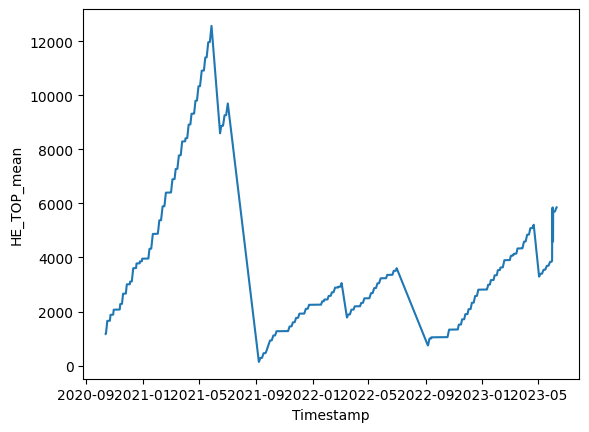

In [164]:
sns.lineplot(df_full["HE_TOP_mean"])

In [166]:
df_full.to_excel("!important_input_files/rdy_for_stats_121020_090623_1h_freq.xlsx")